# Plan
- dict of boolean array of core genome
- for each sample determine % core callable
- plot histogram of this
- dict of number of samples callable at each position
- for each well-covered samples, add to number of callable samples
- plot this genome-wide

In [1]:
%run _standard_imports.ipynb
%run _shared_setup.ipynb
%run _plotting_setup.ipynb

python 3.4.3 |Anaconda 2.2.0 (64-bit)| (default, Mar  6 2015, 12:03:53) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy 1.9.2
scipy 0.15.1
pandas 0.15.2
numexpr 2.3.1
pysam 0.8.3
pysamstats 0.23
petl 1.0.11
petlx 1.0.3
vcf 0.6.7
vcfnp 2.3.0.dev0
h5py 2.4.0
tables 3.1.1


In [2]:
# see 20160525_CallableLoci_bed_release_5.ipynb
lustre_dir = "/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5"
callable_loci_bed_fn_format = "%s/results/callable_loci_%%s.bed" % lustre_dir

plot_dir = "/nfs/team112_internal/rp7/data/pf3k/analysis/20160713_pilot_manuscript_accessibility"
!mkdir -p {plot_dir}

core_regions_fn = "%s/core_regions_20130225.bed" % lustre_dir

callable_loci_fn = "%s/callable_loci_high_coverage_samples.bed" % plot_dir
callable_loci_merged_fn = "%s/callable_loci_merged_samples.bed" % plot_dir

multiIntersectBed = '/nfs/team112_internal/rp7/opt/bedtools/bedtools2/bin/multiIntersectBed'
bedtools = '/nfs/team112_internal/rp7/opt/bedtools/bedtools2/bin/bedtools'

# core_regions_fn = '/nfs/team112_internal/rp7/src/github/malariagen/pf-crosses/meta/regions-20130225.bed.gz'

In [3]:
core_regions_fn

'/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/core_regions_20130225.bed'

In [4]:
REGIONS_FN

'/nfs/team112_internal/rp7/src/github/malariagen/pf-crosses/meta/regions-20130225.bed.gz'

In [5]:
!zgrep Core {REGIONS_FN} > {core_regions_fn}

In [6]:
core_genome_dict = collections.OrderedDict()
for chrom in ['Pf3D7_%02d_v3' % i for i in range(1, 15)]:
    this_chrom_regions = (etl
                          .fromtabix(REGIONS_FN, chrom)
                          .pushheader('chrom', 'start', 'end', 'region')
                          .convertnumbers()
                          )
    chrom_length = np.max(this_chrom_regions.convert('end', int).values('end').array())
    core_genome_dict[chrom] = np.zeros(chrom_length, dtype=bool)
    for rec in this_chrom_regions:
        if rec[3] == 'Core':
            core_genome_dict[chrom][rec[1]:rec[2]] = True

In [7]:
core_genome_length = 0
for chrom in core_genome_dict:
    print(chrom, len(core_genome_dict[chrom]), np.sum(core_genome_dict[chrom]))
    core_genome_length = core_genome_length + np.sum(core_genome_dict[chrom])
print(core_genome_length)

Pf3D7_01_v3 640851 480620
Pf3D7_02_v3 947102 753550
Pf3D7_03_v3 1067971 929971
Pf3D7_04_v3 1200490 932894
Pf3D7_05_v3 1343577 1281978
Pf3D7_06_v3 1418242 1200478
Pf3D7_07_v3 1445207 1204739
Pf3D7_08_v3 1472805 1249936
Pf3D7_09_v3 1541735 1392114
Pf3D7_10_v3 1687656 1502845
Pf3D7_11_v3 2038340 1891043
Pf3D7_12_v3 2271494 2030380
Pf3D7_13_v3 2925236 2715189
Pf3D7_14_v3 3291936 3216370
20782107


In [8]:
tbl_sample_metadata = etl.fromtsv(SAMPLE_METADATA_FN)

In [9]:
tbl_field_samples = tbl_sample_metadata.select(lambda rec: not rec['study'] in ['1041', '1042', '1043', '1104', ''])

In [10]:
len(tbl_field_samples.data())

2512

# Calculate number of core bases callable in each sample

In [16]:
for sample in tbl_field_samples.values('sample'):
    print('.', end='')
    callable_loci_bed_fn = "%s/results/callable_loci_%s.bed" % (lustre_dir, sample)
    core_bases_callable_fn = "%s/results/core_bases_callable_%s.txt" % (lustre_dir, sample)

    if not os.path.exists(core_bases_callable_fn):
        script_fn = "%s/scripts/core_bases_callable_%s.sh" % (lustre_dir, sample)
        fo = open(script_fn, 'w')
        print('''\
grep CALLABLE %s | \
%s intersect -a - -b %s | \
%s genomecov -i - -g %s | \
grep -P 'genome\t1' | \
cut -f 3 > %s
''' % (
                callable_loci_bed_fn,
                bedtools,
                core_regions_fn,
                bedtools,
                GENOME_FN+'.fai',
                core_bases_callable_fn,
            ),
            file = fo
        )
        fo.close()
        st = os.stat(script_fn)
        os.chmod(script_fn, st.st_mode | stat.S_IEXEC)
        bsub(
            '-G', 'malaria-dk',
            '-P', 'malaria-dk',
            '-q', 'normal',
            '-o', '%s/logs/CL_%s.out' % (lustre_dir, sample),
            '-e', '%s/logs/CL_%s.err' % (lustre_dir, sample),
            '-J', 'CBC_%s' % (sample),
            '-R', "'select[mem>1000] rusage[mem=1000]'",
            '-M', '1000',
            script_fn)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [25]:
def read_core_base_callable_file(sample='PF0249-C'):
    core_bases_callable_fn = "%s/results/core_bases_callable_%s.txt" % (lustre_dir, sample)
    with open(core_bases_callable_fn, 'r') as f:
        bases_callable = f.readline()
        if bases_callable == '':
            return(0)
        else:
            return(int(bases_callable))
   

In [26]:
read_core_base_callable_file()

20362999

In [27]:
tbl_field_samples_extended = tbl_field_samples.addfield('core_bases_callable', lambda rec: read_core_base_callable_file(rec[0]))
tbl_field_samples_extended.cut(['sample', 'core_bases_callable'])

sample,acc,study,study_title,contact_name,contact_email,country,site,collection_date,sample_prep,bases,bases_mapped,bases_duplicated,avg_read_length,mean_base_quality,bases_of_1X_coverage,bases_of_5X_coverage,bases_of_10X_coverage,bases_of_50X_coverage,mean_coverage,mean_fragment_size,sd_fragment_size,%callable,core_bases_callable
PA0007-C,ERS010116,1006,Genome-wide analysis of genetic variation in the Gambia,Alfred Amambua-Ngwa,angwa@mrc.gm,The Gambia,GM_Coastal,,,2084040899,2002872367,859315087,75,23.2,22925304,20607683,17717393,9323097,77.03,328.9,144.7,76.94,18134002
PA0008-C,ERS010126,1006,Genome-wide analysis of genetic variation in the Gambia,Alfred Amambua-Ngwa,angwa@mrc.gm,The Gambia,GM_Coastal,,,2540709087,2467552323,461921509,75,23.9,23280178,23094690,22558802,15064542,101.12,343.3,72.5,89.33,20167946
PA0011-C,ERS010043,1006,Genome-wide analysis of genetic variation in the Gambia,Alfred Amambua-Ngwa,angwa@mrc.gm,The Gambia,GM_Coastal,,,3719467019,3587824835,173365999,75,25.8,23129884,23029563,22958094,22173814,153.9,249.7,45,89.56,20213368
PA0012-C,ERS010127,1006,Genome-wide analysis of genetic variation in the Gambia,Alfred Amambua-Ngwa,angwa@mrc.gm,The Gambia,GM_Coastal,,,2916802324,2353658816,215641790,75,24.5,23132891,22693392,21831039,15347174,98.86,252.8,87.6,88.55,20104579
PA0015-C,ERS010044,1006,Genome-wide analysis of genetic variation in the Gambia,Alfred Amambua-Ngwa,angwa@mrc.gm,The Gambia,GM_Coastal,,,4239218388,4046084756,214171152,75,25.8,23174152,23078327,23021067,22518916,173.78,254.9,47.5,89.57,20224102


In [11]:
len(tbl_field_samples.data())

2512

In [72]:
ox_codes = tbl_field_samples.values('sample').array()

In [74]:
def calc_callable_core(callable_loci_bed_fn='/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_PA0007-C.bed'):
    core_bases_callable_fn = callable_loci_bed_fn.replace('.bed', '.core_callable.txt')
    !grep CALLABLE {callable_loci_bed_fn} | \
    {bedtools} intersect -a - -b {core_regions_fn} | \
    {bedtools} genomecov -i - -g {GENOME_FN+'.fai'} | \
    grep -P 'genome\t1' | \
    cut -f 3 > {core_bases_callable_fn}

In [75]:
calc_callable_core()

In [77]:
callable_loci_bed_fns = [callable_loci_bed_fn_format % ox_code for ox_code in ox_codes]
print(len(callable_loci_bed_fns))
callable_loci_bed_fns[0:2]

2512


['/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_PA0007-C.bed',
 '/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_PA0008-C.bed']

In [41]:
def count_symbol(i=1):
    if i%10 == 0:
        return(str((i//10)*10))
    else:
        return('.')

In [ ]:
for i, callable_loci_bed_fn in enumerate(callable_loci_bed_fns):
    print('%s' % count_symbol(i), end='', flush=True)
    calc_callable_core(callable_loci_bed_fn)

0.....

In [43]:
for callable_loci_bed_fn in callable_loci_bed_fns:
    callable_loci_callable_fn = callable_loci_bed_fn.replace('.bed', '.callable.bed')
    !grep CALLABLE {callable_loci_bed_fn} > {callable_loci_callable_fn}

In [43]:
for callable_loci_bed_fn in callable_loci_bed_fns:
    callable_loci_callable_fn = callable_loci_bed_fn.replace('.bed', '.callable.bed')
    !grep CALLABLE {callable_loci_bed_fn} > {callable_loci_callable_fn}

In [71]:
!{bedtools} intersect -a {callable_loci_bed_fn.replace('.bed', '.callable.bed')} -b {core_regions_fn} | \
{bedtools} genomecov -i - -g {GENOME_FN+'.fai'} | grep -P 'genome\t1'
# {bedtools} genomecov -i - -g {GENOME_FN+'.fai'} | grep -P 'genome\t1'

genome	1	20278470	23332839	0.869096


In [44]:
callable_loci_callable_fns = [(callable_loci_bed_fn_format % ox_code).replace('.bed', '.callable.bed') for ox_code in ox_codes]
callable_loci_callable_fns[0:2]

['/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_PA0007-C.callable.bed',
 '/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_PA0008-C.callable.bed']

In [48]:
callable_loci_merged_fn = '/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_merged.bed'
for i, callable_loci_callable_fn in enumerate(callable_loci_callable_fns):
    !cat {callable_loci_callable_fn} >> {callable_loci_merged_fn}
    print('%d' % (i%10), end='', flush=True)


0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789

In [49]:
!sort -k1,1 -k2,2n {callable_loci_merged_fn} > {callable_loci_merged_fn.replace('.bed', '.sort.bed')}

In [51]:
!/nfs/team112_internal/rp7/opt/bedtools/bedtools2/bin/bedtools genomecov \
-i {callable_loci_merged_fn.replace('.bed', '.sort.bed')} \
-g {GENOME_FN+'.fai'} -bga \
> /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_merged_coverage.bed

In [45]:
bedtools_command = '''\
{multiIntersectBed} \
-i {bed_files_list} \
-empty \
-g {genome} \
| cut -f 1-4 \
> {output_filename}'''.format(
    multiIntersectBed = multiIntersectBed,
    bed_files_list = " ".join(callable_loci_callable_fns),
    genome = GENOME_FN+'.fai',
    output_filename = callable_loci_fn
)
!{bedtools_command}


In [53]:
117*13

1521

In [ ]:
bases_callable = collections.OrderedDict()
core_bases_callable = collections.OrderedDict()
autosomes = ['Pf3D7_%02d_v3' % i for i in range(1, 15)]
for i, ox_code in enumerate(tbl_field_samples.values('sample')):
#     print(i, ox_code)
    this_sample_callable_loci = collections.OrderedDict()
    callable_loci_bed_fn = callable_loci_bed_fn_format % ox_code
    for chrom in core_genome_dict.keys():
        chrom_length = len(core_genome_dict[chrom])
        this_sample_callable_loci[chrom] = np.zeros(chrom_length, dtype=bool)
    tbl_this_sample_callable_loci = (etl
                                     .fromtsv(callable_loci_bed_fn)
                                     .pushheader('chrom', 'start', 'end', 'region')
                                     .selecteq('region', 'CALLABLE')
                                     .selectin('chrom', autosomes)
                                     .convertnumbers()
                                    )
    for rec in tbl_this_sample_callable_loci.data():
        this_sample_callable_loci[rec[0]][rec[1]:rec[2]] = True
    bases_callable[ox_code] = 0
    core_bases_callable[ox_code] = 0
    for chrom in core_genome_dict.keys():
        bases_callable[ox_code] = bases_callable[ox_code] + np.sum(this_sample_callable_loci[chrom])
        core_bases_callable[ox_code] = core_bases_callable[ox_code] + np.sum((this_sample_callable_loci[chrom] & core_genome_dict[chrom]))
#     print(ox_code, bases_callable, core_bases_callable)
#     print(i, type(i))
    print('%d' % (i%10), end='', flush=True)
    
        

012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567

In [36]:
20296931 / 20782107 

0.9766541477242899

In [37]:
20782107 * 0.95

19743001.65

In [28]:
proportion_core_callable = tbl_field_samples_extended.values('core_bases_callable').array()/core_genome_length

In [33]:
20155438 / core_genome_length

0.96984574278248115

In [29]:
proportion_core_callable

array([ 0.87257765,  0.97044761,  0.97263324, ...,  0.8348667 ,
        0.95742034,  0.96495711])

In [37]:
for x in [0.98, 0.97, 0.96, 0.95, 0.9, 0.8, 0.5, 0.1, 0.01]:
    print(x, np.sum(proportion_core_callable >= x), np.sum(proportion_core_callable >= x)/2512)

0.98 213 0.0847929936306
0.97 1477 0.587977707006
0.96 1737 0.69148089172
0.95 1848 0.735668789809
0.9 2073 0.825238853503
0.8 2254 0.897292993631
0.5 2467 0.982085987261
0.1 2497 0.99402866242
0.01 2502 0.99601910828


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


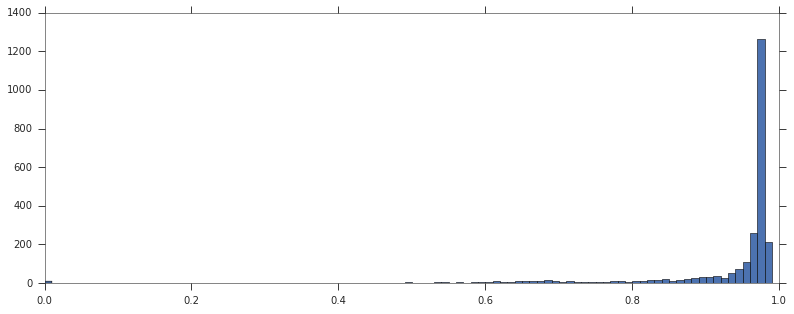

In [30]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(proportion_core_callable, bins=np.linspace(0.0, 1.0, num=101))
fig.tight_layout()
fig.savefig("%s/proportion_core_callable_histogram.pdf" % plot_dir)

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


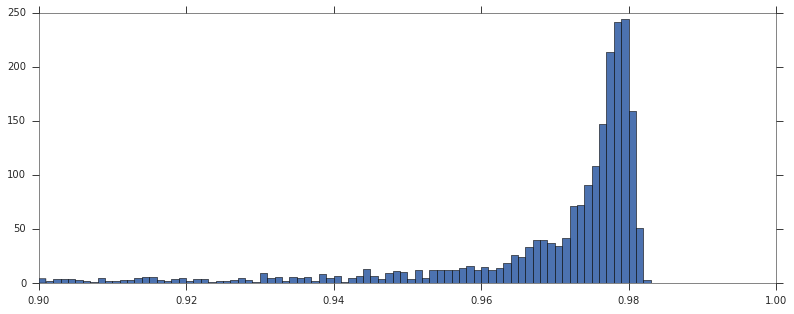

In [31]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1, 1, 1)
ax.hist(proportion_core_callable, bins=np.linspace(0.9, 1.0, num=101))
fig.tight_layout()
fig.savefig("%s/proportion_core_callable_histogram_90.pdf" % plot_dir)

In [44]:
ox_codes = tbl_field_samples_extended.selectge('core_bases_callable', core_genome_length*0.95).values('sample').array(dtype='U12')
len(ox_codes)

1848

In [45]:
ox_codes.dtype

dtype('<U12')

In [38]:
2+2

4

In [46]:
callable_loci_merged_fn = '/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_gt95_merged.bed'
for i, ox_code in enumerate(ox_codes):
    print('%s' % count_symbol(i), end='', flush=True)
    callable_loci_bed_fn = callable_loci_bed_fn_format % ox_code
    !grep CALLABLE {callable_loci_bed_fn} >> {callable_loci_merged_fn}


0.........10.........20.........30.........40.........50.........60.........70.........80.........90.........100.........110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........250.........260.........270.........280.........290.........300.........310.........320.........330.........340.........350.........360.........370.........380.........390.........400.........410.........420.........430.........440.........450.........460.........470.........480.........490.........500.........510.........520.........530.........540.........550.........560.........570.........580.........590.........600.........610.........620.........630.........640.........650.........660.........670.........680.........690.........700.........710.........720.........730.........740.........750.........760.........770.........780.........790.........800.........810.........820.........830.........840

In [47]:
!sort -k1,1 -k2,2n {callable_loci_merged_fn} > {callable_loci_merged_fn.replace('.bed', '.sort.bed')}

In [ ]:
!/nfs/team112_internal/rp7/opt/bedtools/bedtools2/bin/bedtools genomecov \
-i {callable_loci_merged_fn.replace('.bed', '.sort.bed')} \
-g {GENOME_FN+'.fai'} -bga \
> /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_gt95_merged_coverage.bed

In [ ]:
!/nfs/team112_internal/rp7/opt/bedtools/bedtools2/bin/bedtools genomecov \
-i {callable_loci_merged_fn.replace('.bed', '.sort.bed')} \
-g {GENOME_FN+'.fai'} -d \
> /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_gt95_merged_coverage.txt

In [11]:
!bgzip -f /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_gt95_merged_coverage.bed
!bgzip -f /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_gt95_merged_coverage.txt

!tabix -f -p bed /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_gt95_merged_coverage.bed.gz
!tabix -f -s 1 -b 2 -e 2 /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_gt95_merged_coverage.txt.gz


In [11]:
merged_coverage_fn = "/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_gt95_merged_coverage.txt.gz"

accessibility_array = (etl
 .fromtsv(merged_coverage_fn)
 .pushheader(['chrom', 'pos', 'coverage'])
 .convertnumbers()
 .toarray(dtype='a11, i4, i4')
)

In [12]:
merged_coverage_fn = "/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_gt95_merged_coverage.txt.gz"
accessibility_array = np.loadtxt(merged_coverage_fn,
                                 dtype={'names': ('chrom', 'pos', 'coverage'), 'formats': ('U11', 'i4', 'i4')})

MemoryError: 

4294967296

In [25]:
merged_coverage_fn = "/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20160525_CallableLoci_bed_release_5/results/callable_loci_gt95_merged_coverage.txt.gz"

accessibility_array = (etl
 .fromtabix(merged_coverage_fn, region = 'Pf3D7_01_v3', header=['chrom', 'pos', 'coverage'])
 .convertnumbers()
 .toarray()
)

In [13]:
print(len(accessibility_array))
print(accessibility_array[0])
accessibility_array

23332839
(b'Pf3D7_01_v3', 1, 6)


array([(b'Pf3D7_01_v3', 1, 6), (b'Pf3D7_01_v3', 2, 7),
       (b'Pf3D7_01_v3', 3, 16), ..., (b'Pf_M76611', 5965, 1848),
       (b'Pf_M76611', 5966, 1848), (b'Pf_M76611', 5967, 1848)], 
      dtype=[('chrom', 'S11'), ('pos', '<i4'), ('coverage', '<i4')])

In [12]:
accessibility_array_fn = "%s/accessibility_array.npy" % plot_dir
np.save(accessibility_array_fn, accessibility_array)

In [60]:
del(accessibility_array)
gc.collect()

785

In [11]:
accessibility_array_fn = "%s/accessibility_array.npy" % plot_dir
accessibility_array = np.load(accessibility_array_fn)

In [12]:
accessibility_array

array([(b'Pf3D7_01_v3', 1, 6), (b'Pf3D7_01_v3', 2, 7),
       (b'Pf3D7_01_v3', 3, 16), ..., (b'Pf_M76611', 5965, 1848),
       (b'Pf_M76611', 5966, 1848), (b'Pf_M76611', 5967, 1848)], 
      dtype=[('chrom', 'S11'), ('pos', '<i4'), ('coverage', '<i4')])

In [54]:
2+2

4

In [24]:
chrom.encode('ascii')

b'Pf3D7_14_v3'

In [27]:
accessibility_array[accessibility_array['chrom']==chrom.encode('ascii')]['pos']

array([      1,       2,       3, ..., 3291934, 3291935, 3291936], dtype=int32)

In [82]:
(etl
            .fromtsv(REGIONS_FN)
            .pushheader('chrom', 'start', 'end', 'region')
            .convertnumbers()
#              .valuecounts('region').displayall()
        )

chrom,start,end,region
Pf3D7_01_v3,0,27336,SubtelomericRepeat
Pf3D7_01_v3,27336,92900,SubtelomericHypervariable
Pf3D7_01_v3,92900,457931,Core
Pf3D7_01_v3,457931,460311,Centromere
Pf3D7_01_v3,460311,575900,Core


In [79]:
accessibility_colors = {
    'Core': 'white',
    'SubtelomericHypervariable': 'red',
    'InternalHypervariable': 'orange',
    'SubtelomericRepeat': 'brown',
    'Centromere': 'black'
#     'InternalHypervariable': '#b20000',
}



 1000
1 2 3 4 5 6 7 8 9 10 11 12 13 14 

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


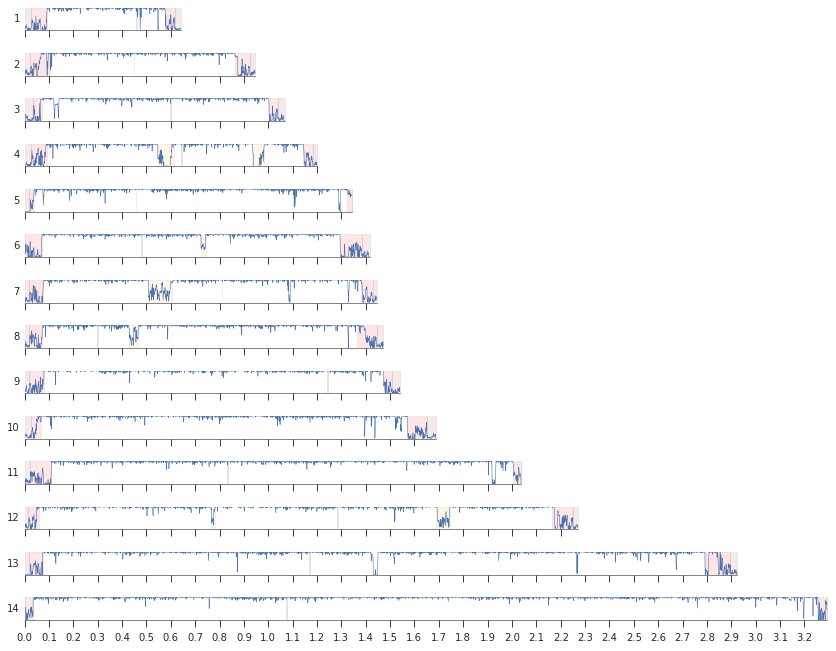

In [83]:
def plot_accessibility(bin_size=1000, number_of_samples = 1848):

    fig = plt.figure(figsize=(11.69*1, 8.27*1))
    gs = GridSpec(2*14, 1, height_ratios=([1.0, 1.0])*14)
    gs.update(hspace=0, left=.12, right=.98, top=.98, bottom=.02)

    print('\n', bin_size)
    for i in range(14):
        print(i+1, end=" ")
        chrom = 'Pf3D7_%02d_v3' % (i + 1)
        pos = accessibility_array[accessibility_array['chrom']==chrom.encode('ascii')]['pos']
        coverage = accessibility_array[accessibility_array['chrom']==chrom.encode('ascii')]['coverage']
        max_pos = np.max(pos)
        if bin_size == 1:
            binned_coverage, bin_centres = coverage, pos
        else:
            binned_coverage, bins, _ = scipy.stats.binned_statistic(pos, coverage, bins=np.arange(1, max_pos, bin_size))
            bin_centres = (bins[:-1]+bins[1:]) / 2
        ax = fig.add_subplot(gs[i*2])
        ax.plot(bin_centres, binned_coverage/number_of_samples)
    #     ax.plot(pos, coverage/number_of_samples)
        ax.set_xlim(0, 3300000)
        ax.set_xticks(range(0, len(core_genome_dict[chrom]), 100000))
        ax.set_xticklabels(np.arange(0, len(core_genome_dict[chrom])/1e+6, 0.1))
        tbl_regions = (etl
            .fromtabix(REGIONS_FN, chrom)
            .pushheader('chrom', 'start', 'end', 'region')
            .convertnumbers()
        )
        for region_chrom, start_pos, end_pos, region_type in tbl_regions.data():
            if region_type != 'Core':
                ax.axvspan(start_pos, end_pos, facecolor=accessibility_colors[region_type], alpha=0.1)
        for s in 'left', 'right', 'top':
            ax.spines[s].set_visible(False)
    #         ax.set_yticklabels([])
        ax.get_xaxis().tick_bottom()
        ax.set_yticks([])

        ax.set_ylabel(i+1, rotation='horizontal', horizontalalignment='right', verticalalignment='center')

        ax.set_xlabel('')
        if i < 13:
            ax.set_xticklabels([])
    #     ax.spines['top'].set_bounds(0, len(core_genome_dict[chrom]))    
        ax.spines['bottom'].set_bounds(0, len(core_genome_dict[chrom]))
    
    fig.savefig(os.path.join(plot_dir, 'short_read_accesibility_%dbp_windows.png' % bin_size), dpi=150)
    fig.savefig(os.path.join(plot_dir, 'short_read_accesibility_%dbp_windows.pdf' % bin_size))

plot_accessibility()


 100000
1 2 3 4 5 6 7 8 9 10 11 12 13 14 
 10000
1 2 3 4 5 6 7 8 9 10 11 12 13 14 
 1000
1 2 3 4 5 6 7 8 9 10 11 12 13 14 
 1
1 2 3 4 5 6 7 8 9 10 11 12 13 14 

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


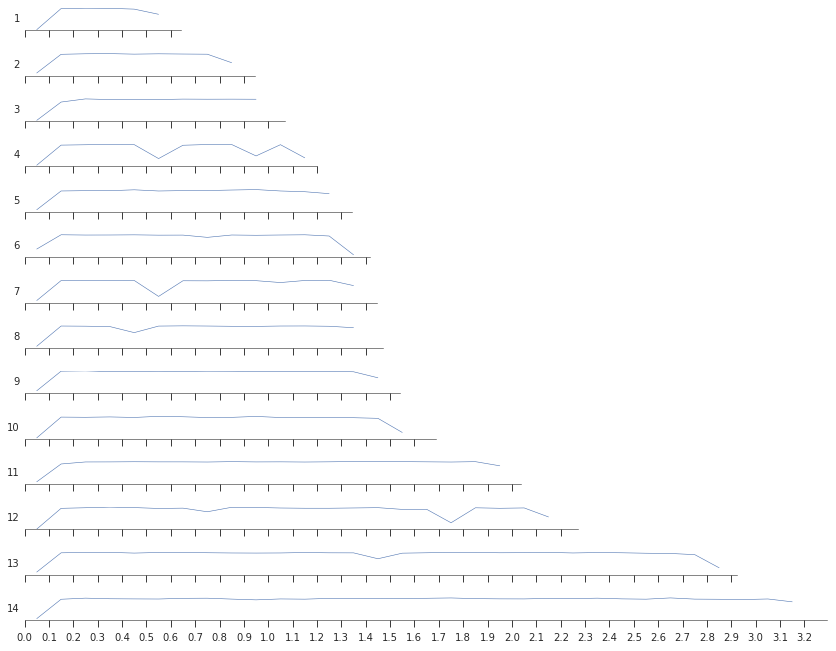

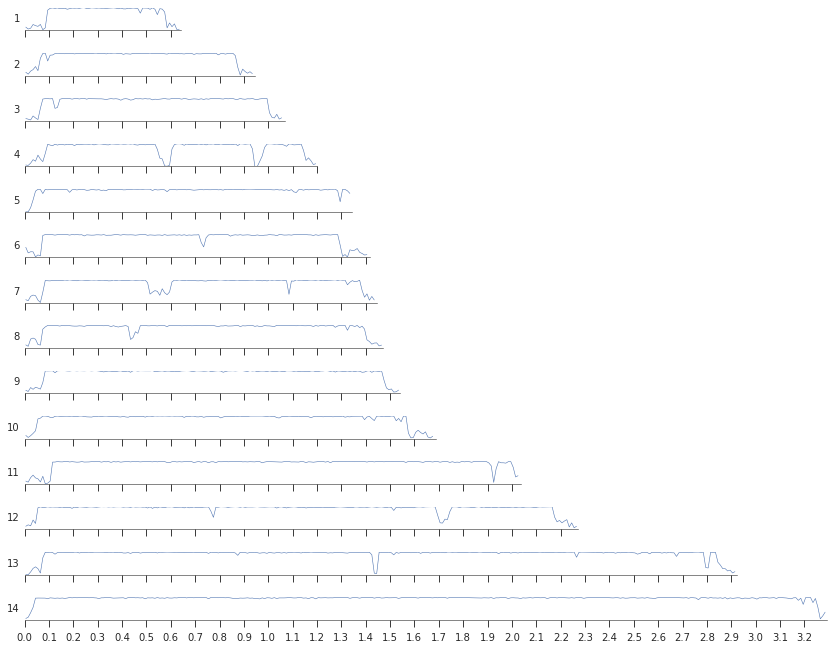

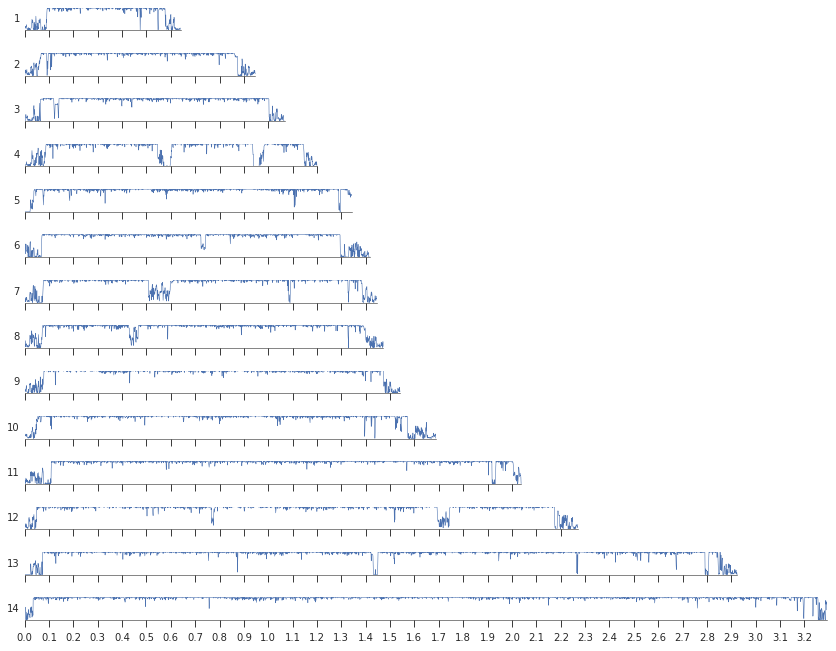

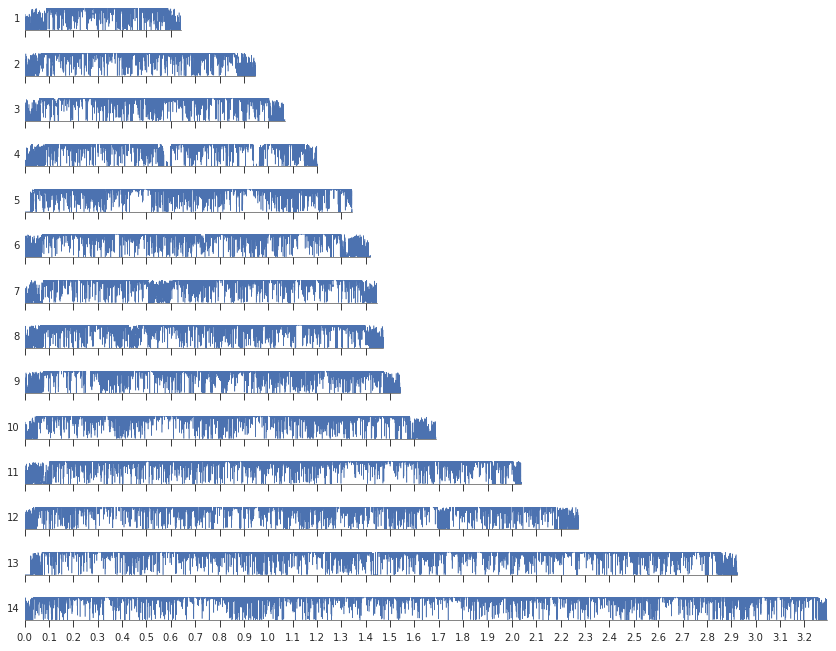

In [45]:
# for bin_size in [100000, 10000, 1000, 100, 10, 1]:
for bin_size in [100000, 10000, 1000, 1]:
    plot_accessibility(bin_size)


 500
1 2 3 4 5 6 7 8 9 10 11 12 13 14 
 300
1 2 3 4 5 6 7 8 9 10 11 12 13 14 

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


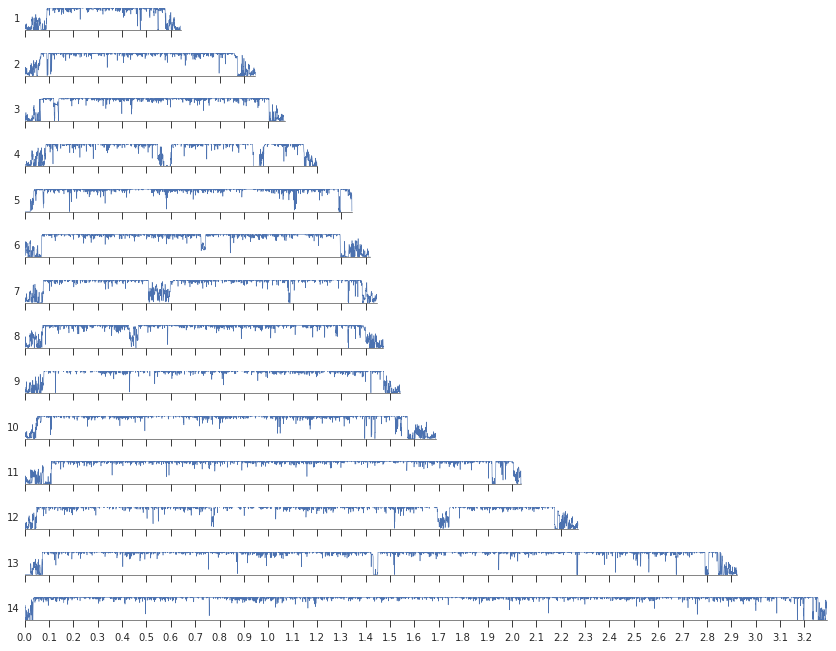

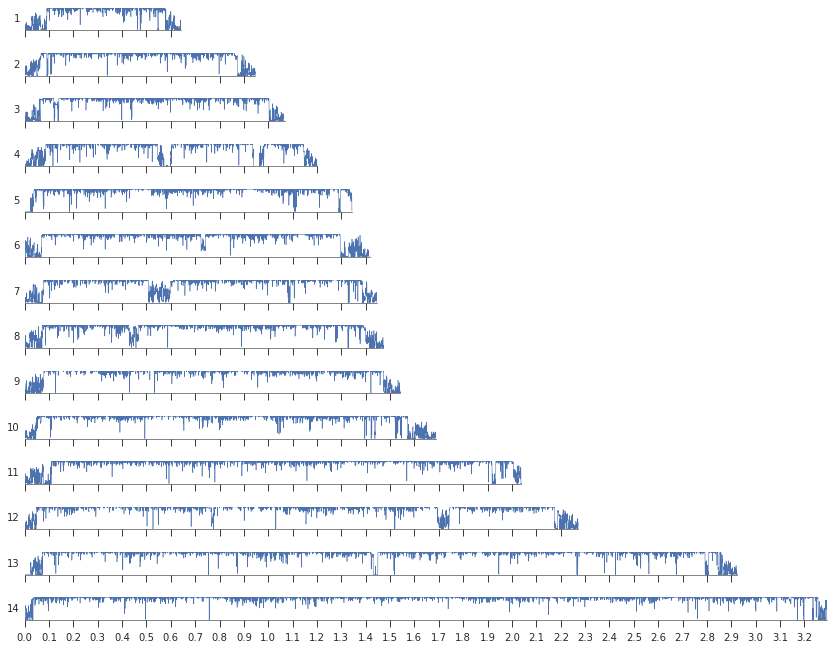

In [72]:
# for bin_size in [100000, 10000, 1000, 100, 10, 1]:
for bin_size in [500, 300]:
    plot_accessibility(bin_size)


 100
1 2 3 4 5 6 7 8 9 10 11 12 13 14 
 10
1 2 3 4 5 6 7 8 9 10 11 12 13 14 

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


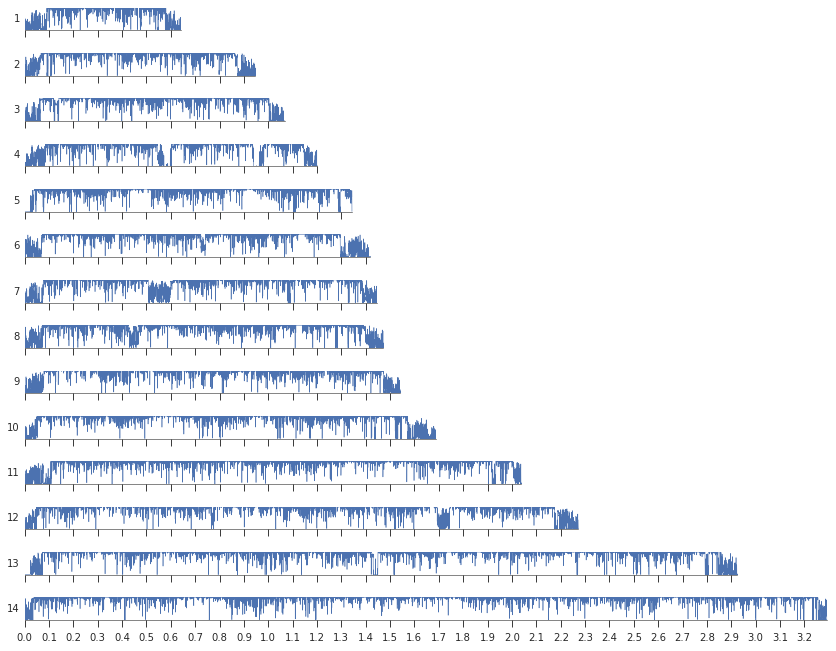

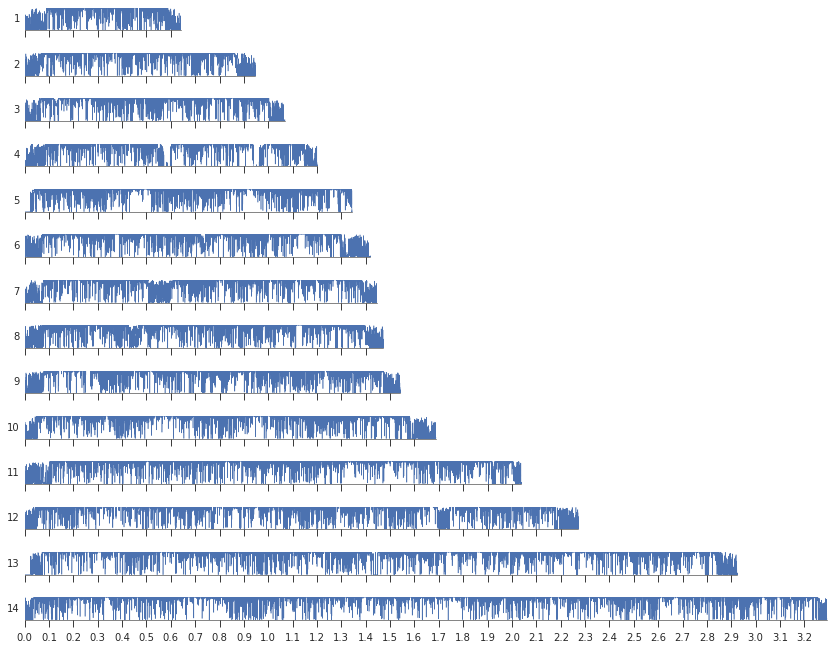

In [74]:
# for bin_size in [100000, 10000, 1000, 100, 10, 1]:
for bin_size in [100, 10]:
    plot_accessibility(bin_size)

In [86]:
def plot_accessibility_region(chrom='Pf3D7_10_v3', start=1.4e+6, end=1.44e+6, bin_size=1000, number_of_samples = 1848,
                              tick_distance=5000):

    fig = plt.figure(figsize=(8, 3))

    pos_array = (
        (accessibility_array['chrom']==chrom.encode('ascii')) &
        (accessibility_array['pos']>=start) &
        (accessibility_array['pos']<=end)
    )
    pos = accessibility_array[pos_array]['pos']
    coverage = accessibility_array[pos_array]['coverage']
    min_pos = np.min(pos)
    max_pos = np.max(pos)
    print(min_pos, max_pos)
    if bin_size == 1:
        binned_coverage, bin_centres = coverage, pos
    else:
        binned_coverage, bins, _ = scipy.stats.binned_statistic(pos, coverage, bins=np.arange(min_pos, max_pos, bin_size))
        bin_centres = (bins[:-1]+bins[1:]) / 2
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(bin_centres, binned_coverage/number_of_samples)
    ax.set_xlim(min_pos, max_pos)
#     ax.set_xlim(0, 3300000)
    ax.set_xticks(range(min_pos, max_pos+1, tick_distance))
    ax.set_xticklabels(np.arange(min_pos/1e+6, (max_pos+1)/1e+6, tick_distance/1e+6))
#         for region_chrom, start_pos, end_pos, region_type, region_size in tbl_regions.data():
#             if chrom == region_chrom and region_type != 'Core':
#                 ax.axvspan(start_pos, end_pos, facecolor=accessibility_colors[region_type], alpha=0.1)
    for s in 'left', 'right', 'top':
        ax.spines[s].set_visible(False)
#         ax.set_yticklabels([])
    ax.get_xaxis().tick_bottom()
    ax.set_yticks([])

#     ax.set_ylabel(i+1, rotation='horizontal', horizontalalignment='right', verticalalignment='center')

    ax.set_xlabel('')
    ax.spines['bottom'].set_bounds(min_pos, max_pos)
    
    fig.savefig(os.path.join(plot_dir, 'short_read_accesibility_%dbp_windows_%s_%d_%d.png' % (bin_size, chrom, start, end)), dpi=150)
    fig.savefig(os.path.join(plot_dir, 'short_read_accesibility_%dbp_windows_%s_%d_%d.pdf' % (bin_size, chrom, start, end)))



1400000 1440000
1400000 1440000
1400000 1440000
1400000 1440000


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


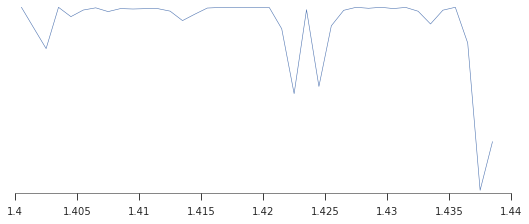

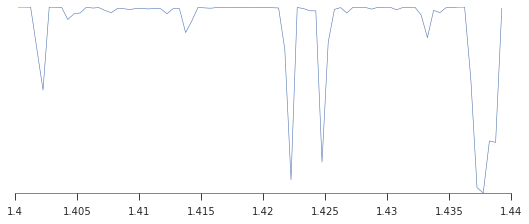

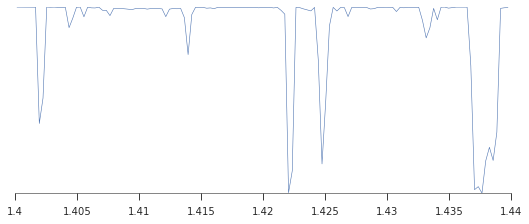

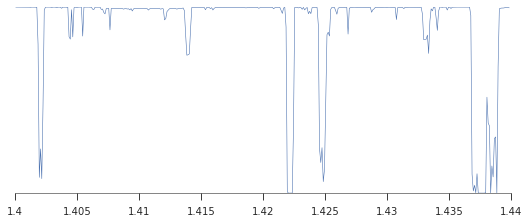

In [73]:
for bin_size in [1000, 500, 300, 100]:
    plot_accessibility_region(bin_size=bin_size)

1200000 1600000


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


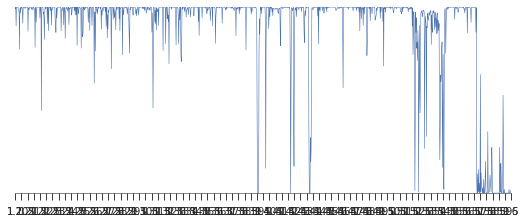

In [71]:
plot_accessibility_region(start=1.2e+6, end=1.6e+6, bin_size=300)

1400000 1500000


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


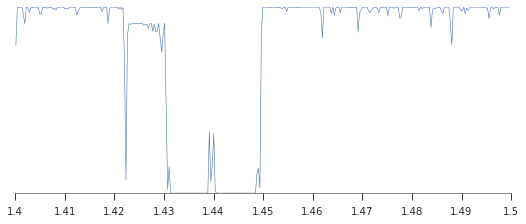

In [93]:
# RH2a and RH2b
plot_accessibility_region(chrom='Pf3D7_13_v3', start=1.4e+6, end=1.5e+6, bin_size=300, tick_distance=10000)

1410000 1460000


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


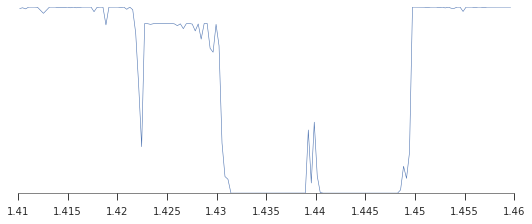

In [94]:
# RH2a and RH2b
plot_accessibility_region(chrom='Pf3D7_13_v3', start=1.41e+6, end=1.46e+6, bin_size=300, tick_distance=5000)

1400000 1440000


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


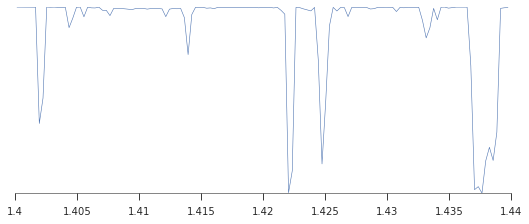

In [95]:
# MSP region
plot_accessibility_region(bin_size=300)

403000 406500


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


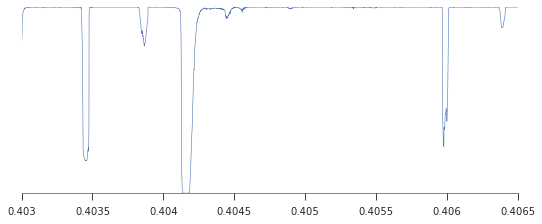

In [109]:
# CRT region
plot_accessibility_region(chrom='Pf3D7_07_v3', start=403000, end=406500, bin_size=1, tick_distance=500)


 10000
1 2 3 4 5 6 7 8 9 10 11 12 13 14 
 1000
1 2 3 4 5 6 7 8 9 10 11 12 13 14 
 100
1 2 3 4 5 6 7 8 9 10 11 12 13 14 
 1
1 2 3 4 5 6 7 8 9 10 11 12 13 14 

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


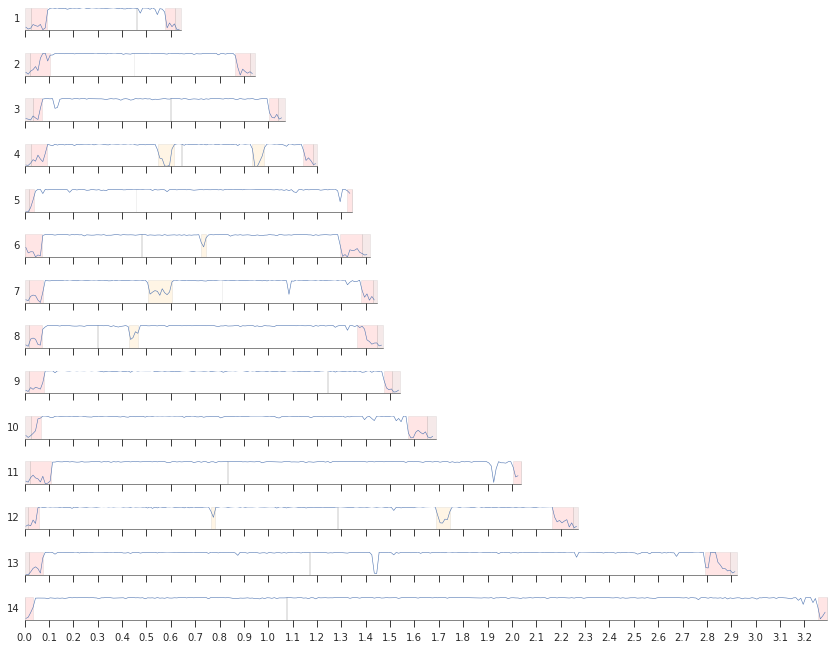

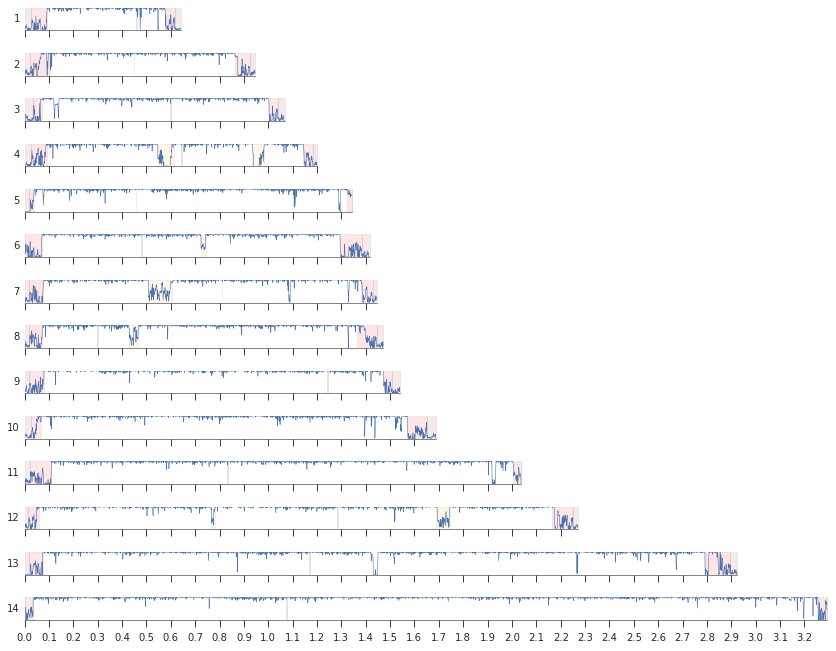

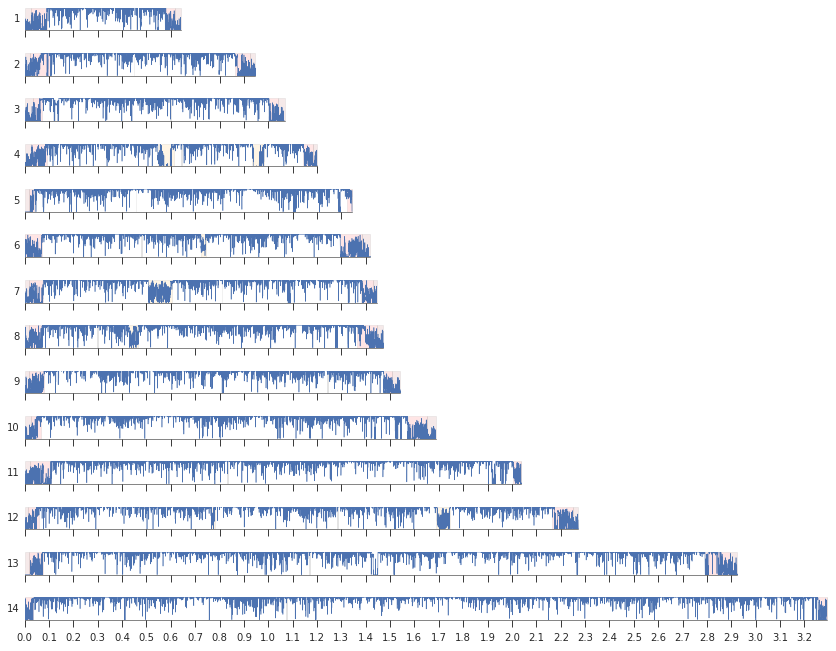

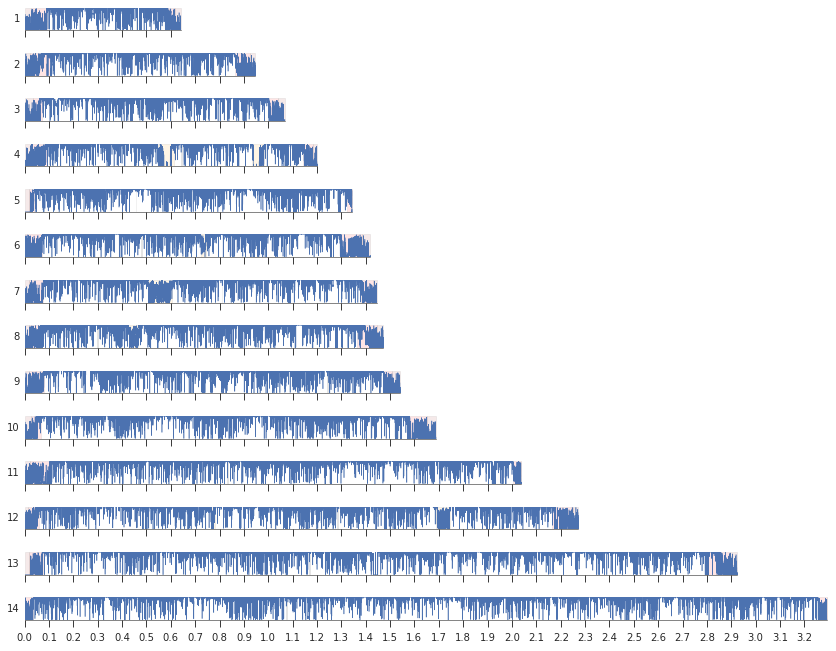

In [96]:
# WG for Thomas
for bin_size in [10000, 1000, 100, 1]:
    plot_accessibility(bin_size)

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


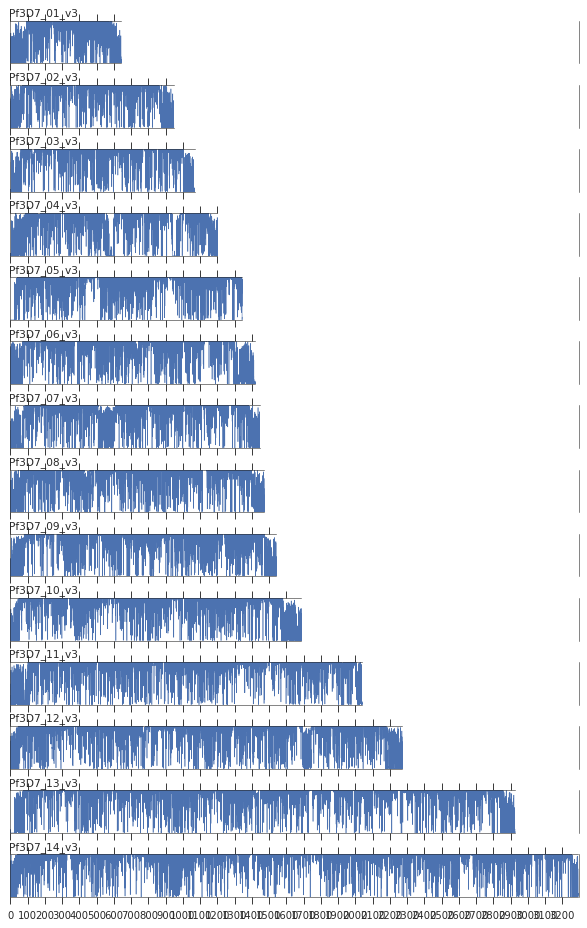

In [27]:
number_of_samples = 1848

fig = plt.figure(figsize=(11.69*2, 8.27*2))
gs = GridSpec(2*14, 1, height_ratios=([1.0, 0.5])*14)
gs.update(hspace=0, left=.12, right=.98, top=.98, bottom=.02)

for i in range(14):
    print(i, end=" ")
    chrom = 'Pf3D7_%02d_v3' % (i + 1)
    accessibility_array = (etl
        .fromtabix(merged_coverage_fn, region = chrom, header=['chrom', 'pos', 'coverage'])
        .cut(['pos', 'coverage'])
        .convertnumbers()
        .toarray()
    )
    ax = fig.add_subplot(gs[i*2])
    ax.plot(accessibility_array['pos'], accessibility_array['coverage']/number_of_samples)
    ax.set_xlim(0, 3300000)
    ax.set_xticks(range(0, len(core_genome_dict[chrom]), 100000))
    ax.set_xticklabels(range(0, int(len(core_genome_dict[chrom])/1000), 100))
#         for region_chrom, start_pos, end_pos, region_type, region_size in tbl_regions.data():
#             if chrom == region_chrom and region_type != 'Core':
#                 ax.axvspan(start_pos, end_pos, facecolor=accessibility_colors[region_type], alpha=0.1)
#         for s in 'left', 'right':
#             ax.spines[s].set_visible(False)
#             ax.set_yticklabels([])
    ax.set_yticks([])

    ax.set_title(chrom, loc='left')

    ax.set_xlabel('')
    if i < 13:
        ax.set_xticklabels([])
    ax.spines['top'].set_bounds(0, len(core_genome_dict[chrom]))    
    ax.spines['bottom'].set_bounds(0, len(core_genome_dict[chrom]))    



In [110]:
2+2

4